<a href="https://colab.research.google.com/github/MittalMonika/DataScience/blob/master/Yolov7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **End-to-end document table extraction and summarization pipeline leveraging computer vision and natural language processing technique**

Below is brief outline of the steps that need to be executed for the workflow

1. Read document (pdf) from a given location.
2. Split the document into pages and covert each page into png/jpg format and save with appropriate naming convention
3. Use  trained&deployee YOLO model to mark table boundaries
4. Extract sub Images by cutting those tables out of original images.
5. Perform OCR on tables and extract the text matrix
6. Send the text to openai and generate a summary of the table.
---




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/yolov7

/content/drive/MyDrive/yolov7


In [ ]:
!ls /content/drive/MyDrive/yolo_fab/



# 1. Read document (pdf) from a given location

To read a document on goole colab
 that isIt is easy to upload document to google drive but To read a document that is not on Google Drive and we don't want to upload it manually each time we can use Google Colab following steps


*   Upload Directly to google drive and note the path where the document is uploaded : go to the folder and upload the document "/content/drive/MyDrive/yolov7/Pdf_document/AutomateDocument.pdf"
*   If is not on Google Drive and we don't want to upload it manually each time and its availabe as a online URL document (see below)



In [ ]:
document_name = "AutomateDocument.pdf"
constant_path = "/content/drive/MyDrive/yolov7/Pdf_document/"
pdf_file = constant_path + document_name
outdir = document_name.replace(".pdf", "")
output_dir =constant_path + "Pdf_To_Images/" + outdir
output_dir_ = output_dir +"/"
inf_dir = output_dir_ + "detect2/"

# the directory from which the weights are taken for inference
#model_dir = "/content/drive/MyDrive/model_clean/weights/best.pt"
model_dir = "runs/train/exp6/weights/last.pt"

In [ ]:
import requests

# Replace the URL with the link to your PDF document
pdf_url = "https://www.bls.gov/osmr/research-papers/2014/pdf/st140030.pdf"
headers = {
    "Referer": "https://www.bls.gov/osmr/research-papers/"
}
# Fetch the PDF content from the URL
response = requests.get(pdf_url, headers=headers)
# Check if the request was successful (status code 200)
if response.status_code == 403:
    # Access the PDF content as bytes
    pdf_content = response.content
    # To save the PDF content to a local file in Colab:
    with open("/content/drive/MyDrive/yolov7/Pdf_document/AutomateDocument.pdf", "wb") as pdf_file:
        pdf_file.write(pdf_content)
    #Open and manipulate the local file in Colab.
else:
    print("Failed to fetch the PDF document from the URL.")


# 2. Split the document into pages and covert each page into png/jpg format and save them with appropriate naming convention

*   For this we use package pdf2image and Poppler




In [ ]:
!pip install pdf2image
# Install Poppler
!apt-get install poppler-utils

# Restart the runtime to apply changes (necessary for some installations)
#import os
#os.kill(os.getpid(), 9)

In [ ]:
import os
from pdf2image import convert_from_path
# Specify the PDF file path
os.makedirs(output_dir, exist_ok=True)
#os.mkdir(output_dir)
# Convert PDF to a list of PNG images
images = convert_from_path(pdf_file)

# Save PNG images to files
for i, image in enumerate(images):
    image.save(os.path.join(output_dir, f"output_page_{i + 1}.png"), "PNG")
print("The images are saved in ", output_dir)

The images are saved in  /content/drive/MyDrive/yolov7/Pdf_document/Pdf_To_Images/AutomateDocument


# 3. Use trained & deploy YOLO model to mark table boundaries
## Training YOLOv7 on a Custom Dataset (identify Tables)

Yolov7 [YOLOv7 repository](https://github.com/WongKinYiu/yolov7) by WongKinYiu is used to performs training on own custom objects and here i am using a document set and trying to tag tables from the scanned/screenshot images


### **Steps that are followed**

To train the yolov7 follow steps:

* Install YOLOv7 and all its dependencies
* Load custom dataset here i took document-parts dataset
* Run YOLOv7 training
* Evaluate YOLOv7 performance
* Run YOLOv7 inference on test images

### Preparing a Custom Dataset

Annotating the dataset : As a important step we need to annotate the dataset. Yolov7 basically need a file which has a same name of the image and annotation text images_1.jpg images_1.txt. here images_1.txt conatins the co-ordinates of a bounding box basically defining our object to be tagged. There are some tools which we can use like LabelImg which basically will create a same textfile name  as of image but manually we need to draw one/multiple bounding to tag different parts that image conatins

Split dataset basically into train,test, validation folder

In this i am taking an open source computer vision dataset from [Roboflow Universe](https://universe.roboflow.com)

For future when we need our own images (and, optionally, annotations), we can convert your dataset using [Roboflow](https://roboflow.com), a set of tools use to build better computer vision models quickly and accurately. It say it can be used for (automatic) annotation, converting dataset formats (like to YOLOv7), training, deploying, and improving their datasets/models.


In [3]:
# Download YOLOv7 repository and install requirements
#!git clone https://github.com/WongKinYiu/yolov7
#%cd yolov7
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00



1. A GitHub repository where we can clone the yolov7 model and then activate this simple commands to set the environment
2. The official repository contain pre-trained weights for the model which we can use as a stating point instead of some arbitary weights

In [ ]:
# download COCO starting checkpoint
%cd /content/drive/MyDrive/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt



Ready for preprocessing of our Model
 1.Training   
 2.Custom Config file for training
        1. we need to define a customized configuration file as the training process will be entirely dependent on that file
            2. basically this file
                1. defines image path (test,train,validation)
                2. Number of classes : nc : numbercount
                3. classes_array_name : manes__=[‘table’]

 We can train the model and configure some of the arguments to the model like
					- img = size of images on which model will train; the default value is 640.
					— batch-size = batch size used for custom dataset training.
					— epochs = number of training epochs to get the best model
					— data = custom config file path
					— weights = pretrained yolov7 weights

	Note : If any image is corrupted, training will not begin. If any label file is corrupted, training will not begin because yolov7 will ignore that image and label files. so we need to check all these things before


In [ ]:
#  Training (dnt run this cell)
!python train.py --batch 16 --epochs 50 --data document-parts-2/data.yaml --weights 'yolov7_training.pt' --device 0

2023-10-05 03:13:29.894336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 03:13:31.228357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 2023-9-26 torch 2.0.1+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='', data='document-parts-2/data.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=50, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='exp', exist_ok=False, quad=False, linear_lr=False,

After training we have some custom trained weights basically which are save after the model is run and usually save in as the name best.pt

In [ ]:
!python test.py --weights runs/train/exp6/weights/best.pt --task test --data document-parts-2/data.yaml

In [ ]:
!rm -rf /content/drive/MyDrive/yolov7/Pdf_document/Pdf_To_Images/1_Automate_Document/detect2/

The model is already save running trai.py and then we can have inference using the following command we we have automate the output dir and it is save in the detect dir with a folder name same as document under Pdf_document/Pdf_To_Images/

e.g . Pdf_document/Pdf_To_Images/1_Automate_Document/detect

In [ ]:
import subprocess
# Run the command using subprocess
command = [
    "python",
    "detect.py",
    "--weights",
    model_dir,
    "--conf",
    "0.3",
    "--source",
    output_dir_,
    "--name",
    inf_dir,
    "--save-txt"
]
subprocess.run(command)


CompletedProcess(args=['python', 'detect.py', '--weights', 'runs/train/exp6/weights/last.pt', '--conf', '0.3', '--source', '/content/drive/MyDrive/yolov7/Pdf_document/Pdf_To_Images/AutomateDocument/', '--name', '/content/drive/MyDrive/yolov7/Pdf_document/Pdf_To_Images/AutomateDocument/detect/', '--save-txt'], returncode=0)

In [ ]:
!python detect.py --weights runs/train/exp6/weights/best.pt --conf 0.3 --source Pdf_To_Images/ --save-txt

# 4. Extract sub Images by cutting those tables out of original images.

In [ ]:
import cv2
import os

# Define the directory containing the images and text files

image_directory = inf_dir
text_directory = inf_dir + "labels/"
output_directory = inf_dir + "TagTable/"



# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Loop through the image files in the directory
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(".png"):  # Assuming your images are in JPEG format
        image_path = os.path.join(image_directory, image_filename)

        # Load the image
        img = cv2.imread(image_path)

        # Load the corresponding text file
        text_filename = os.path.splitext(image_filename)[0] + ".txt"
        text_path = os.path.join(text_directory, text_filename)

        # Check if the text file exists
        if os.path.exists(text_path):
            # Read and parse the YOLO annotations from the text file
            with open(text_path, "r") as file:
                lines = file.readlines()
                table_counter = 1  # Counter for naming tables
                for line in lines:
                    # Parse the YOLO annotation (class_id, x_center, y_center, width, height)
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())

                    # Convert YOLO coordinates to OpenCV coordinates
                    x1 = int((x_center - width / 2) * img.shape[1])
                    y1 = int((y_center - height / 2) * img.shape[0])
                    x2 = int((x_center + width / 2) * img.shape[1])
                    y2 = int((y_center + height / 2) * img.shape[0])

                    # Crop the table from the image based on the coordinates
                    table = img[y1:y2, x1:x2]

                    # Generate a filename for the extracted table
                    table_filename = os.path.splitext(image_filename)[0] + f"_table_{table_counter}.jpg"
                    table_path = os.path.join(output_directory, table_filename)

                    # Save the extracted table as a new image
                    cv2.imwrite(table_path, table)

                    # Increment the table counter
                    table_counter += 1

# Optionally, you can add error handling, resizing, or other processing as needed


# 5. Perform OCR on tables and extract the text matrix

In [ ]:
import cv2
import pytesseract

# Load the image with tables
image_path = output_directory
# 'Pdf_To_Images/TagTable/output_page_12_table_1.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale for better OCR accuracy
#gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use pytesseract to perform OCR on the grayscale image
#ocr_result = pytesseract.image_to_string(gray_image)
ocr_result = pytesseract.image_to_string(image)

# Split the OCR result into lines
lines = ocr_result.split('\n')

# Initialize an empty matrix to store the table data
table_matrix = []

# Iterate through the lines to extract and construct the matrix
for line in lines:
    # Split each line by tab or space, depending on your table's formatting
    cells = line.split('\t')  # You can also try ' ' or other delimiters
    cleaned_cells = [cell.strip() for cell in cells if cell.strip()]  # Remove empty cells

    if cleaned_cells:
        table_matrix.append(cleaned_cells)

# Print the extracted matrix
for row in table_matrix:
    print(row)


['Completed Training Credentials']
['(Exiters) (Exiters)']
['Ne early']
['2013']
['Rate of Credentialing']


# EXTRA CODE
### Draw annotations for train and test data or any other file you would like having your image and txt file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['output_page_1.png', 'output_page_7.png', 'output_page_8.png', 'output_page_4.png', 'output_page_3.png', 'output_page_2.png', 'output_page_6.png', 'output_page_5.png', 'detect', 'detect2', 'detect3', 'detect4', 'detect5']
total number of images in this directory is : 13
output_page_7.png 0 0.508529 0.365227 0.685294 0.111364

Name is:  0 output_page_7.png


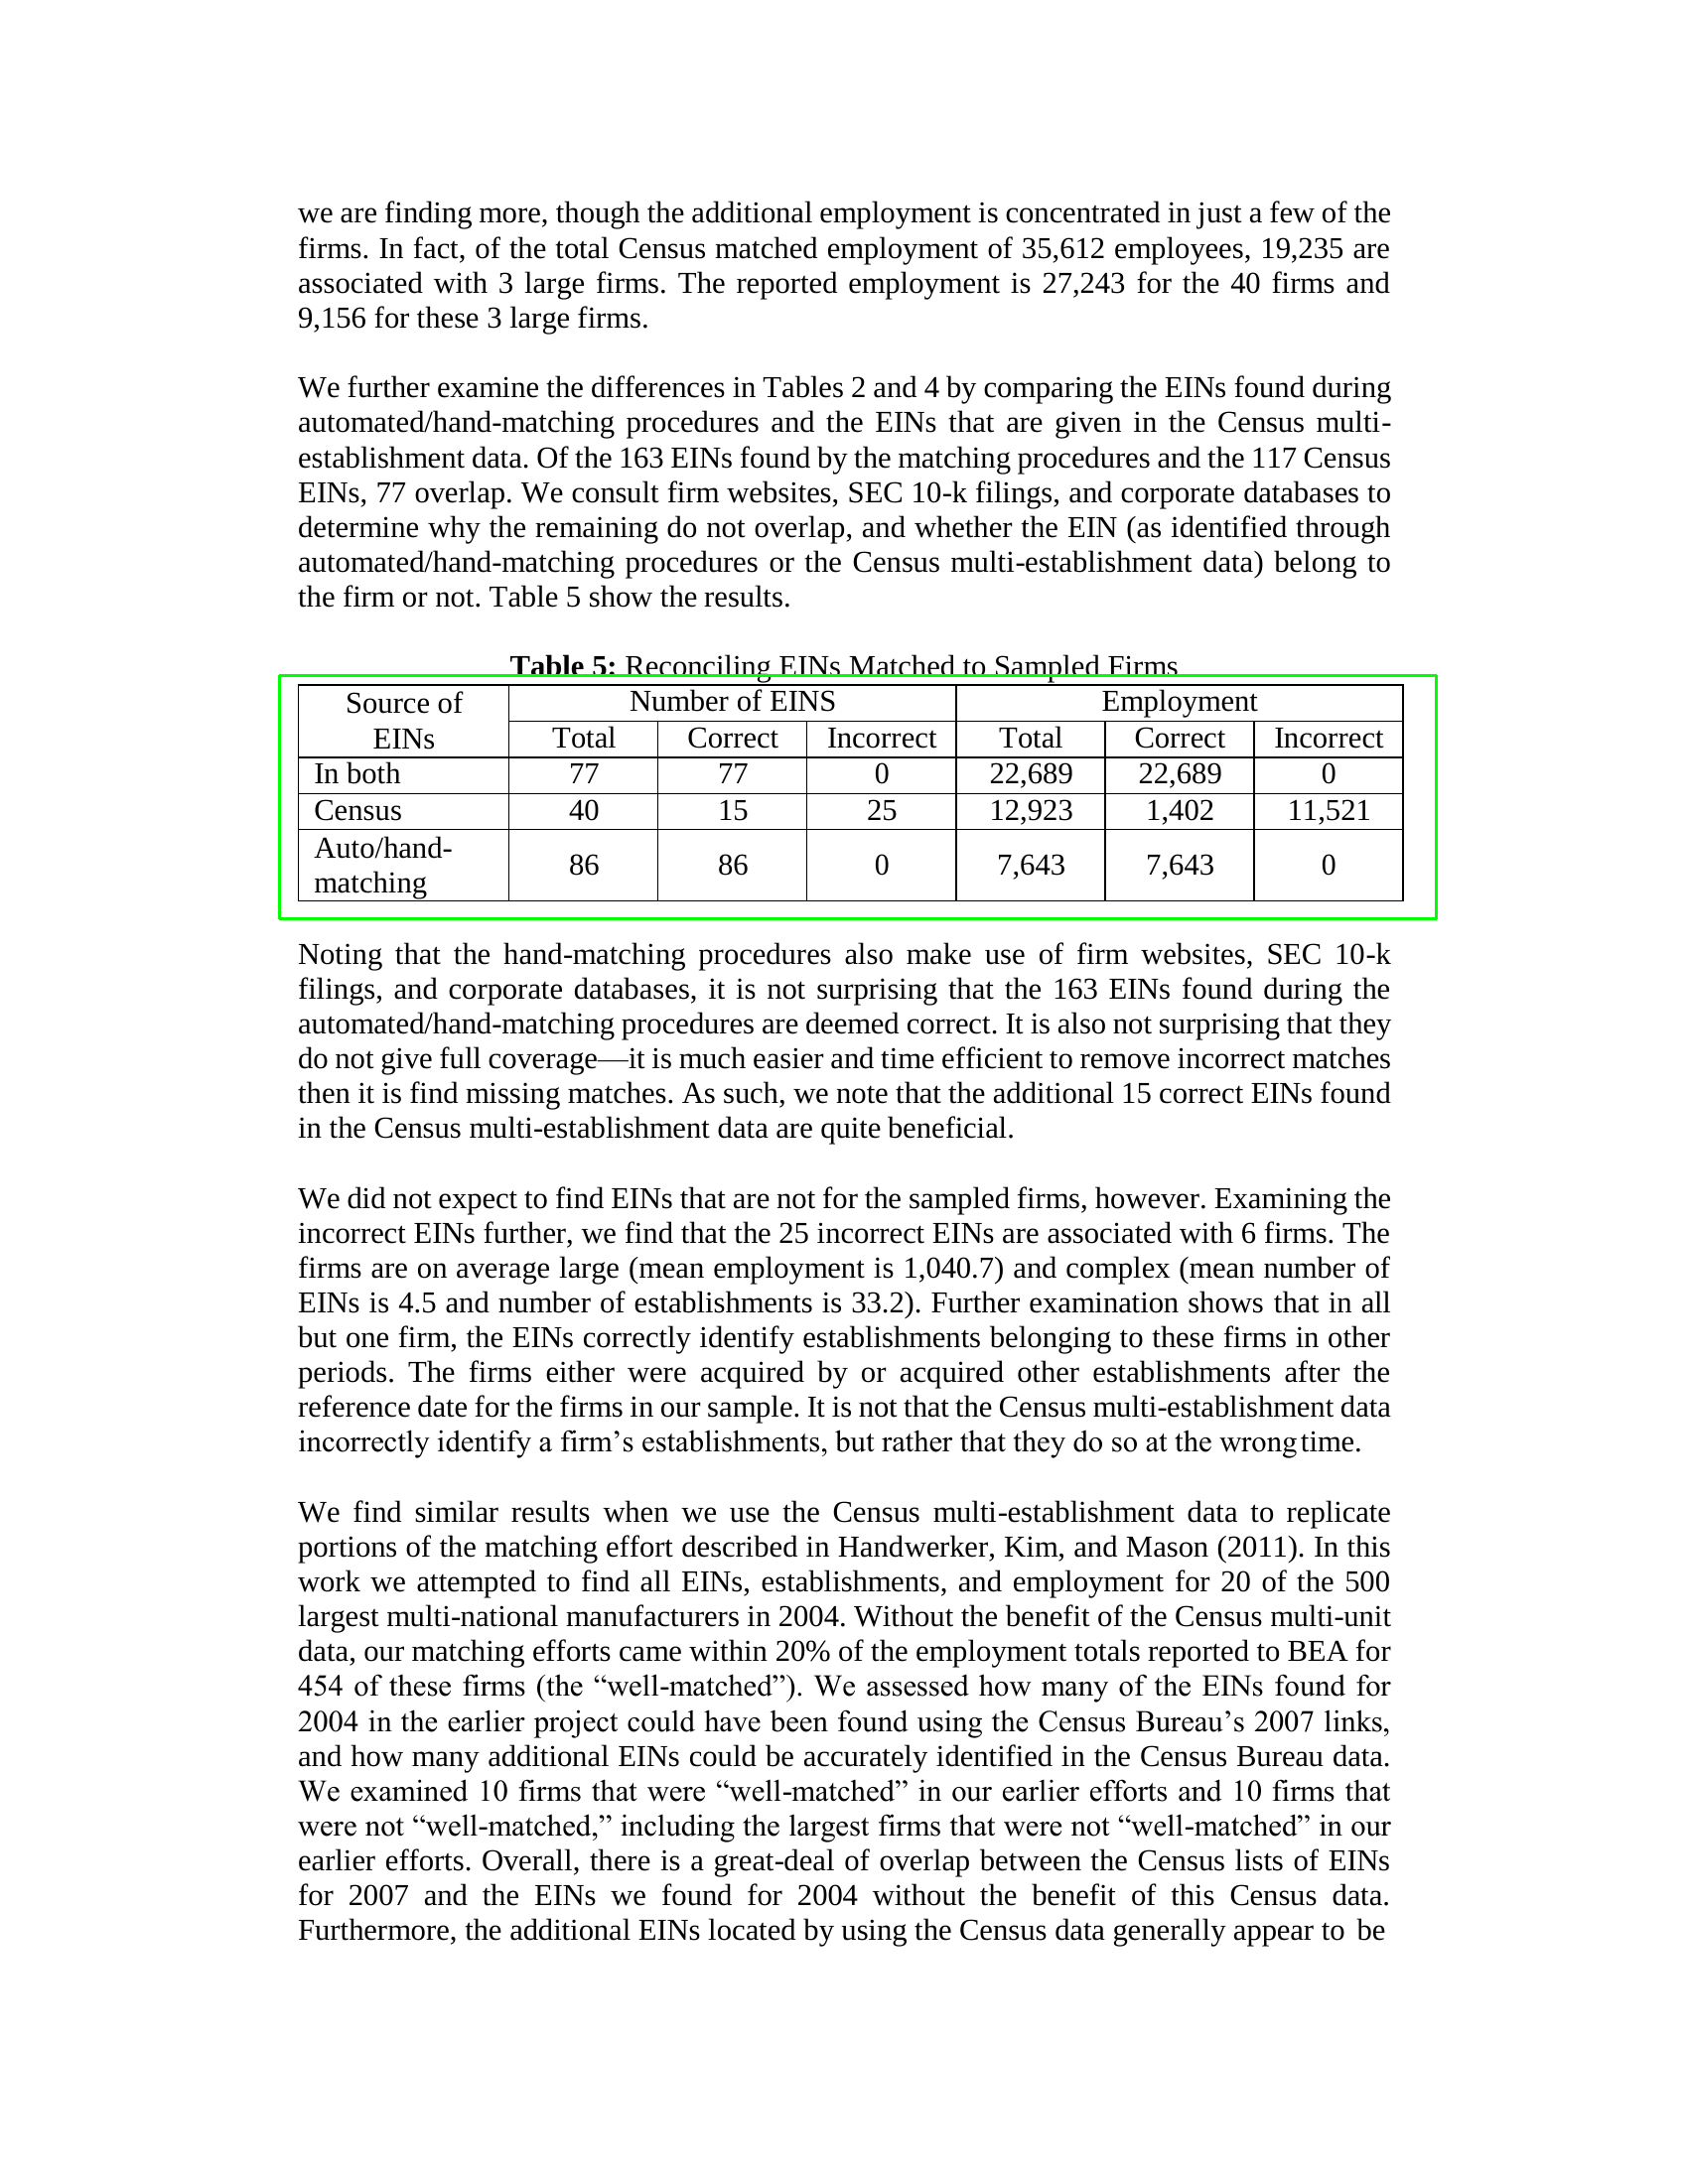

output_page_4.png 0 0.500588 0.767273 0.676471 0.0954545

Name is:  1 output_page_4.png


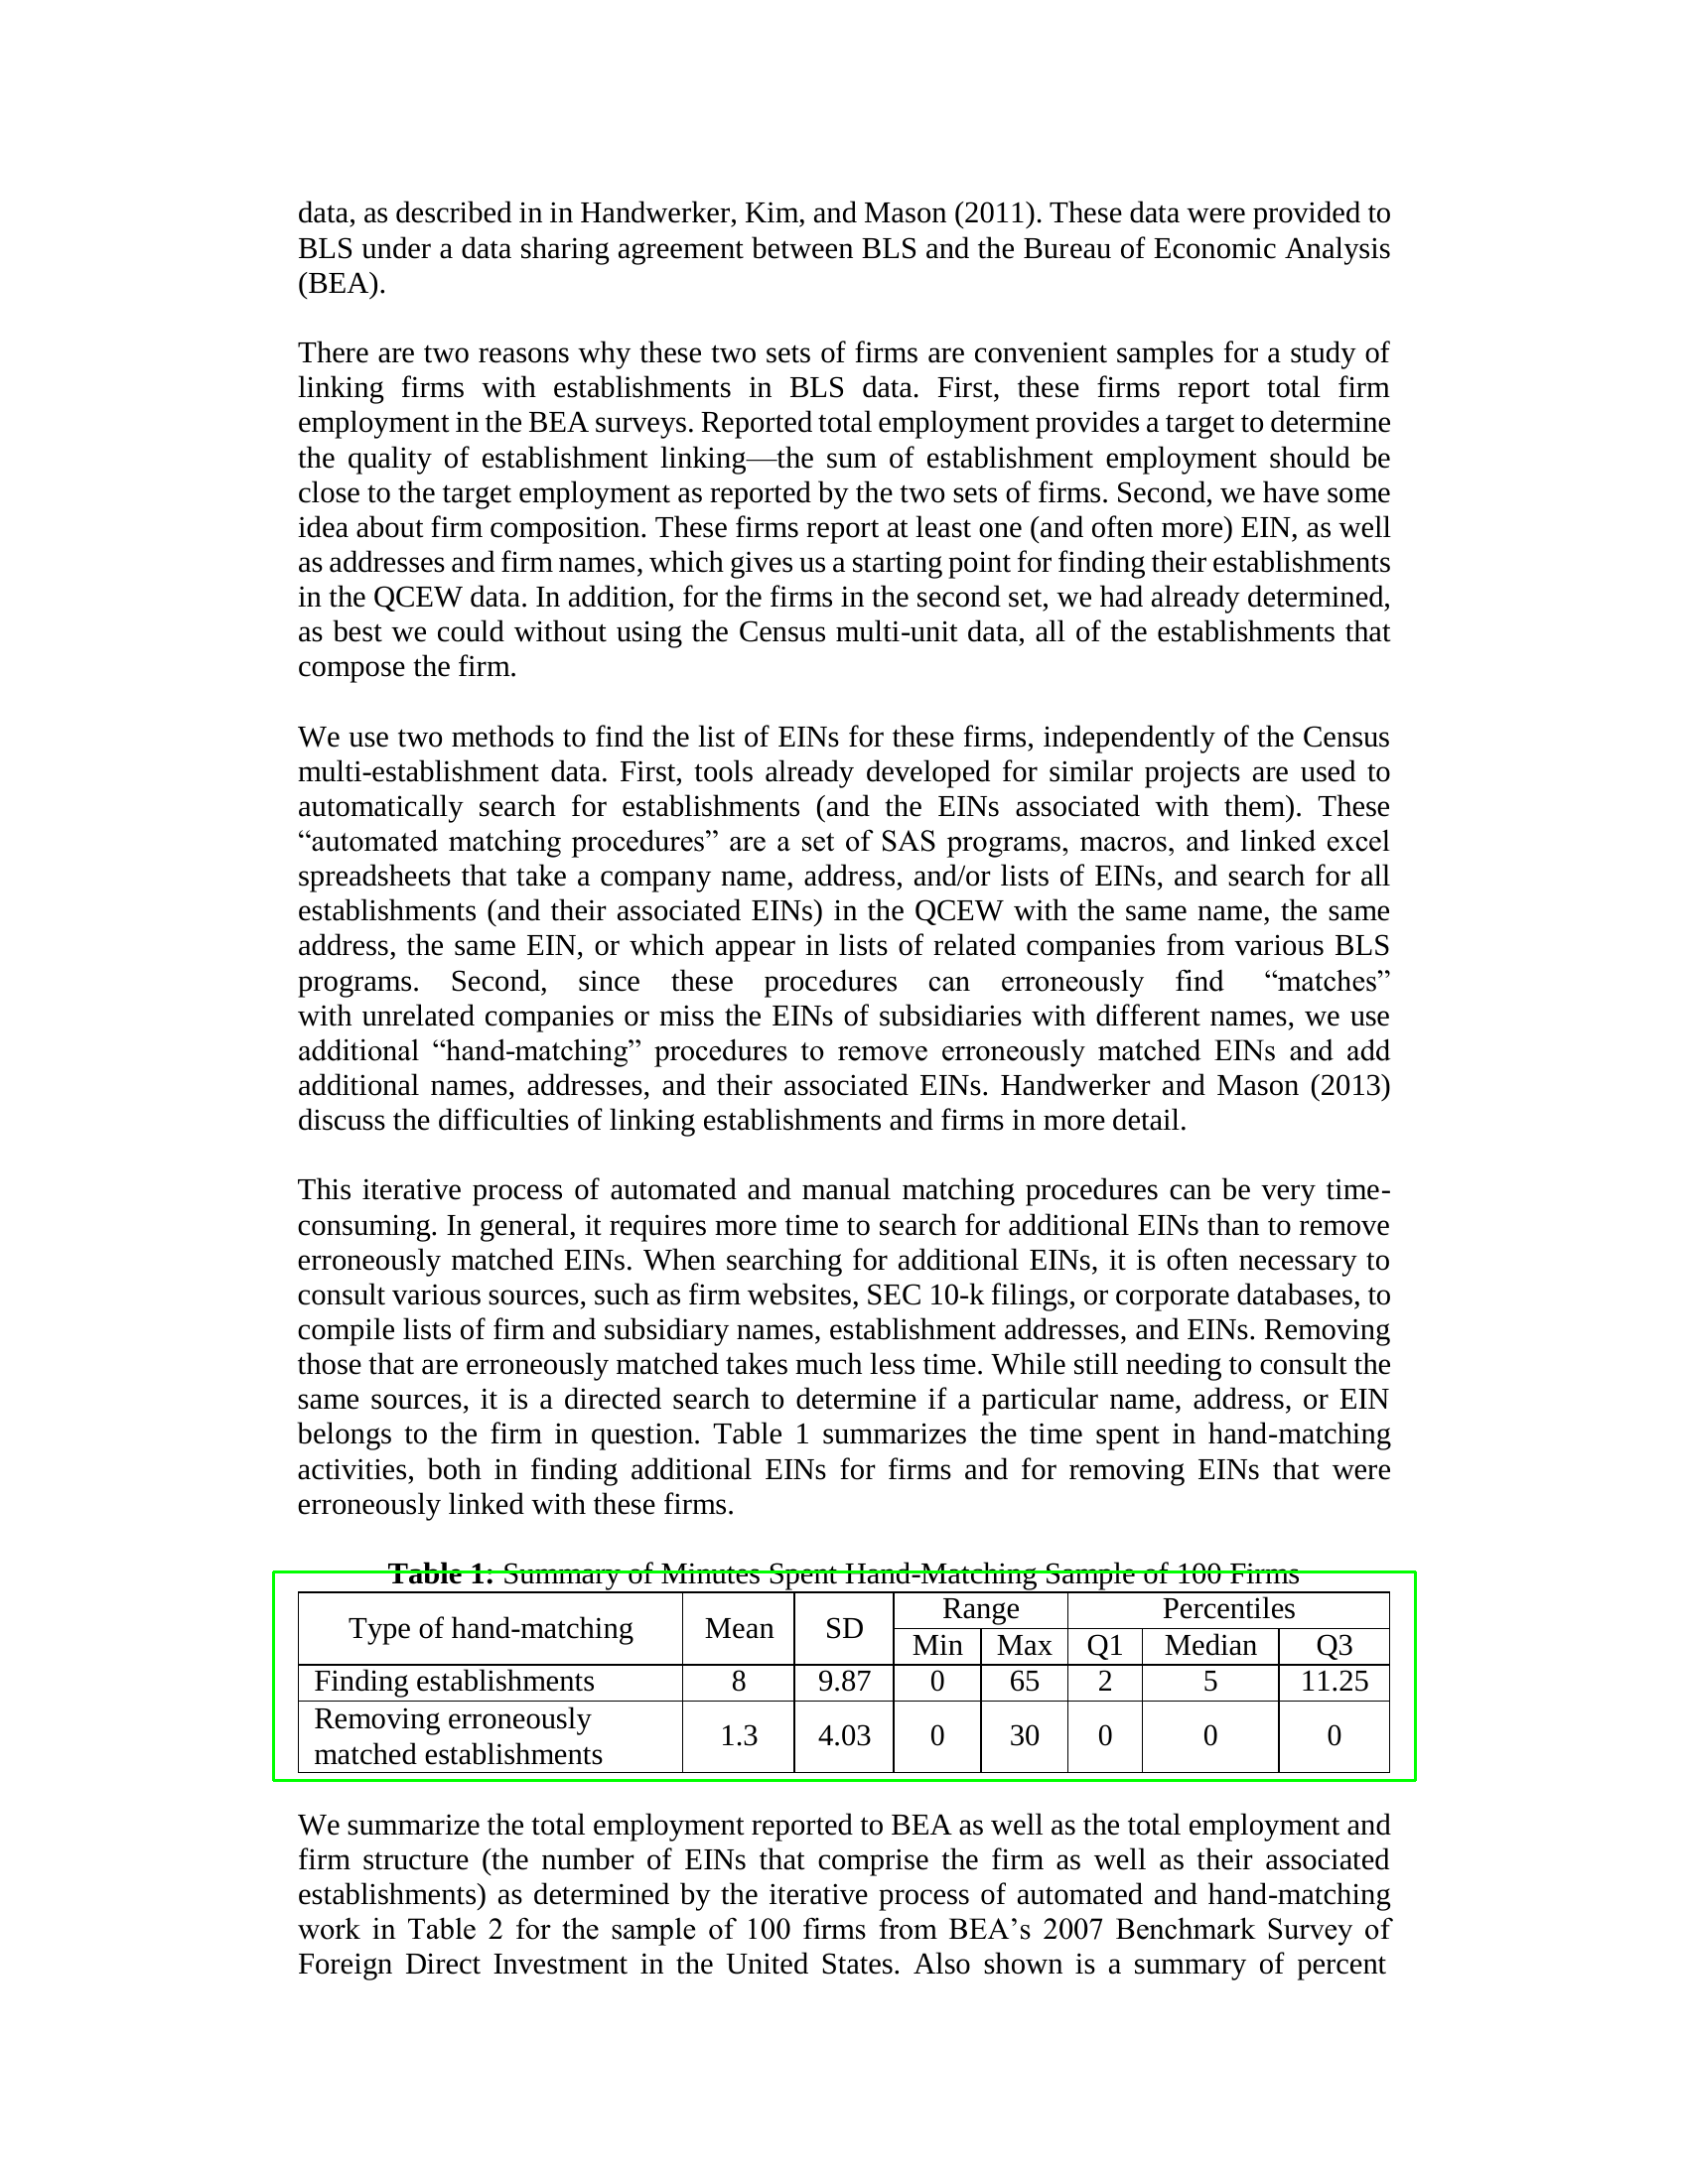

output_page_6.png 0 0.510294 0.727273 0.668824 0.251818

output_page_6.png 0 0.499118 0.327955 0.687647 0.111364
Name is:  2 output_page_6.png


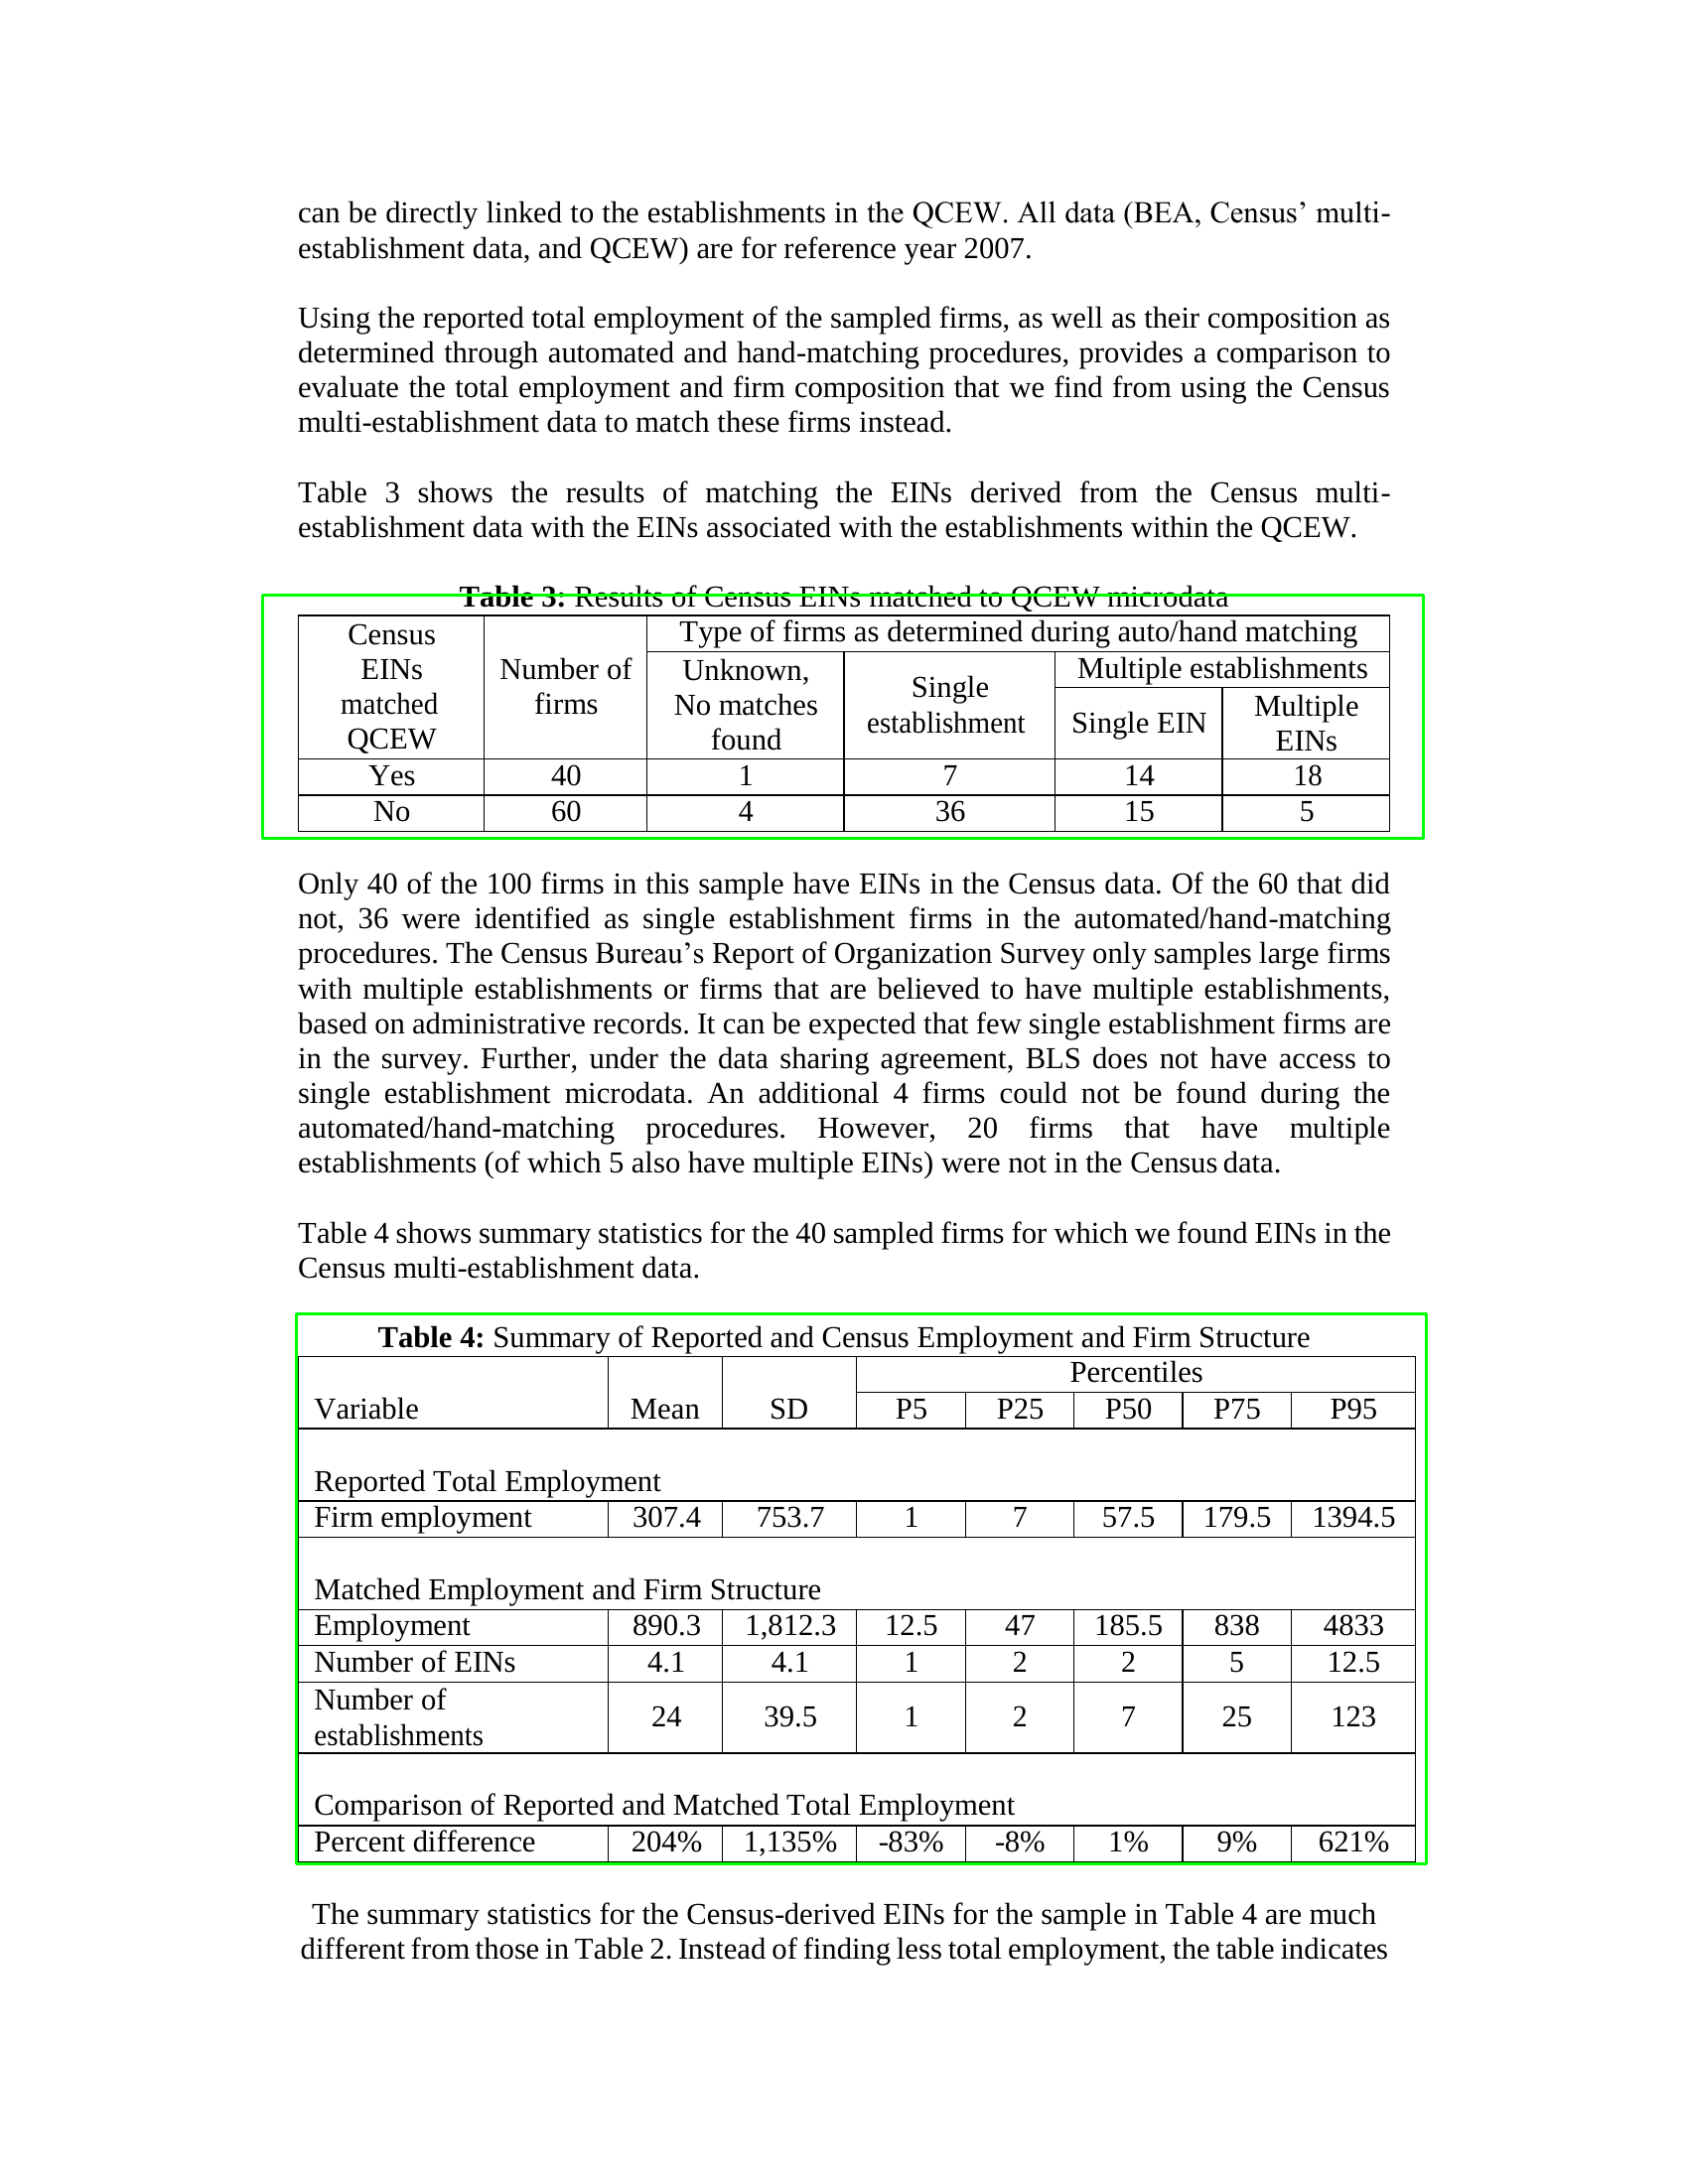

output_page_5.png 0 0.510294 0.26273 0.668824 0.251818
Name is:  3 output_page_5.png


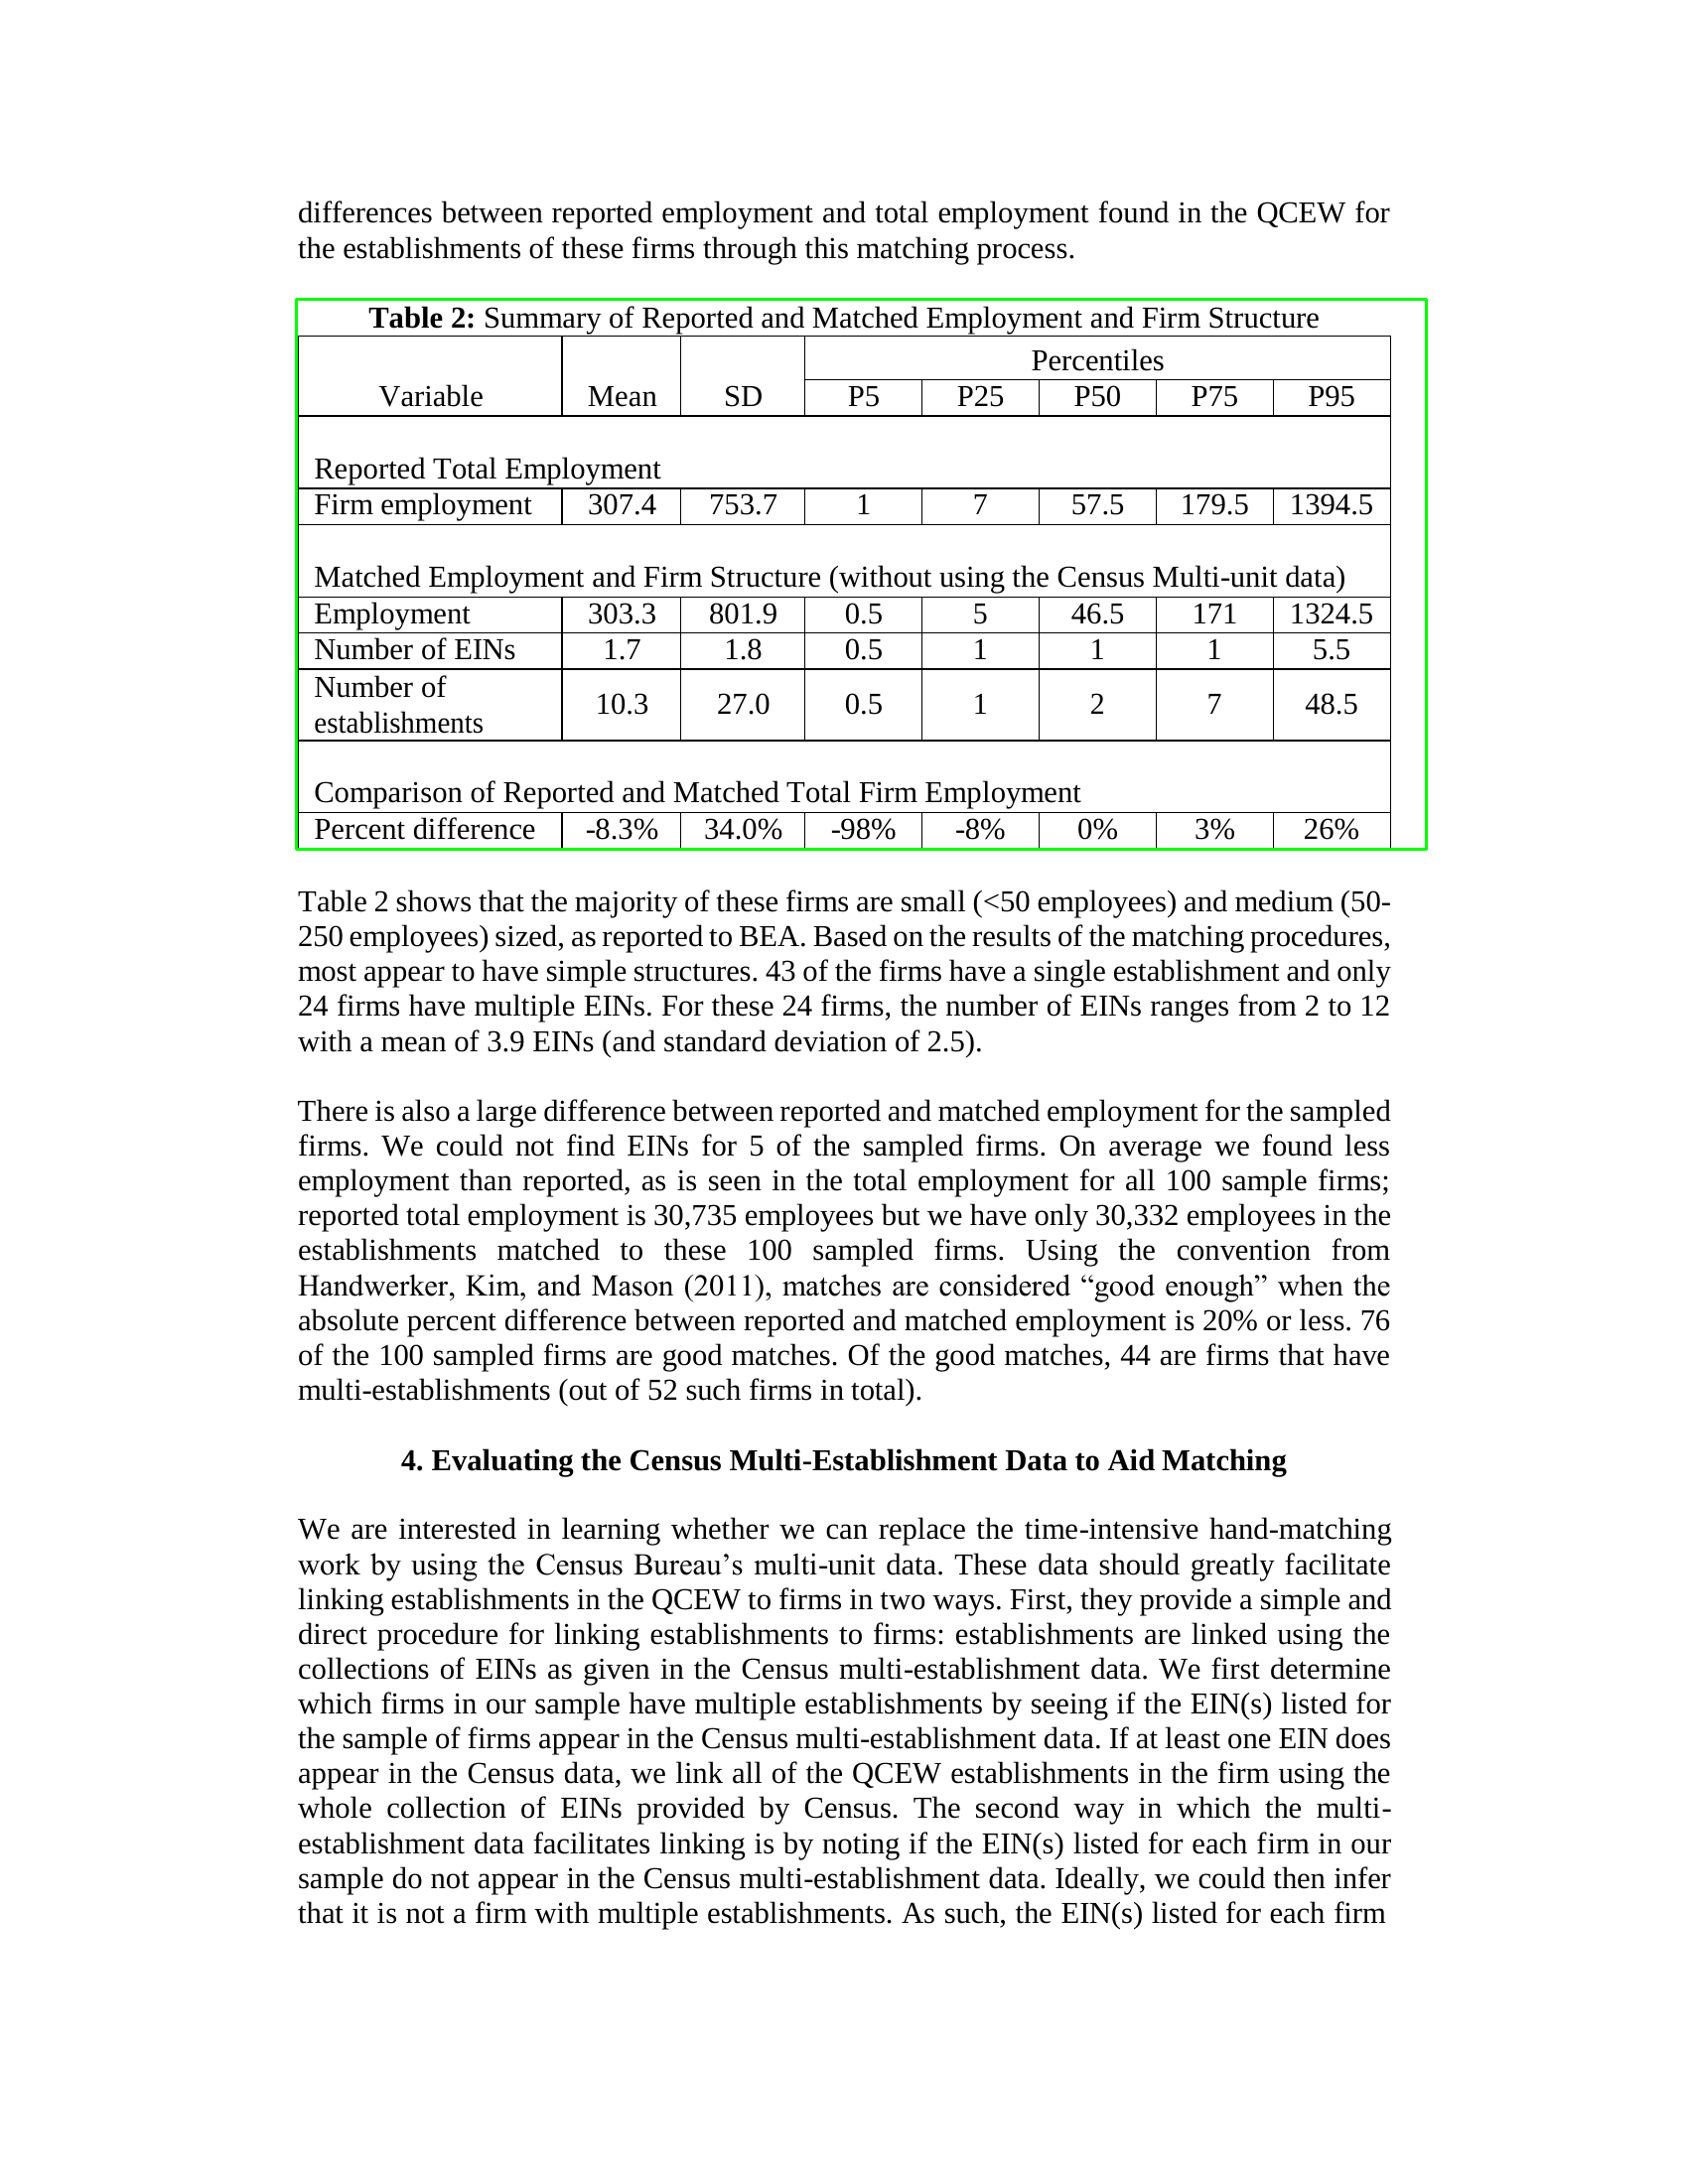

Annotation and display completed.


In [ ]:
import cv2
import os
from IPython.display import Image, display

# Mount Google Drive to access your data (optional, if your data is in Google Drive)
from google.colab import drive
drive.mount('/content/drive')
#os.rmdir("/content/drive/MyDrive/yolov7/document-parts-2/Annotated")
#os.mkdir("/content/drive/MyDrive/yolov7/document-parts-2/Annotated")
# Directory containing images and label files
anno_dir ="/content/drive/MyDrive/yolov7/document-parts-2/Annotated"
data_dir = output_dir_
data_dir_labels =  inf_dir + "labels"
file_list = os.listdir(data_dir)
print(file_list)


# Counter to limit the number of images displayed
display_count = 0


print("total number of images in this directory is :", len(file_list))


# Loop through each image in the directory
for image_file in file_list:
    if image_file.endswith(".png"):  # Adjust the file extension as needed
        # Load the image
        image_path = os.path.join(data_dir, image_file)
        image = cv2.imread(image_path)

        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(data_dir_labels, label_file)

        # Read label annotations from the YOLO format file
        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
          with open(label_path, "r") as label_file:
            lines = label_file.readlines()

          for line in lines:
            print(image_file, line)
            # Parse the YOLO annotation (x_center, y_center, width, height)
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            # Convert YOLO coordinates to OpenCV coordinates
            x1 = int((x_center - width / 2) * image.shape[1])
            y1 = int((y_center - height / 2) * image.shape[0])
            x2 = int((x_center + width / 2) * image.shape[1])
            y2 = int((y_center + height / 2) * image.shape[0])

            # Draw a bounding box on the image
            color = (0, 255, 0)  # Green color (BGR format)
            thickness = 2  # Line thickness
            image = cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

          # Save the annotated image within Google Colab
          output_image_file = os.path.join(anno_dir, "annotated_" + image_file)
          cv2.imwrite(output_image_file, image)

          # Display the annotated image using IPython
          print("Name is: ",display_count,image_file )
          display(Image(output_image_file))

          # Increment the counter
          display_count += 1

          # Check if we've displayed 100 images
          #if display_count >= 100:
           #   break  # Stop displaying images

# Print a message when the task is completed
print("Annotation and display completed.")


In [ ]:
#display Inference on ALL test images/valid/train dataset

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/drive/MyDrive/yolov7/runs/detect/exp5/*.png'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1


In [ ]:
import cv2
import numpy as np
from google.colab import files  # To upload images in Colab

# Upload the document image to Colab
uploaded = files.upload()

# Assuming you uploaded a file named "document_with_pink_box.jpg"
document_image = cv2.imread("runs/detect/exp4/output_page_10.png")

# Convert the image to grayscale
gray_image = cv2.cvtColor(document_image, cv2.COLOR_BGR2GRAY)

# Define the lower and upper pink/purple color range in HSV
lower_color = np.array([140, 50, 50])  # Adjust these values for pink/purple color
upper_color = np.array([170, 255, 255])

# Create a mask for the pink/purple color
mask = cv2.inRange(document_image, lower_color, upper_color)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if contours:
    # Get the largest contour (assuming it's the pink/purple bounding box)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates (x, y, width, height)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the bounded region from the original image
    cropped_region = document_image[y:y+h, x:x+w]

    # Save or further process the cropped region
    cv2.imwrite("cropped_region.jpg", cropped_region)
else:
    print("No pink/purple bounding box found in the document.")

# Display or save the cropped region as needed
cv2.imshow("Cropped Region", cropped_region)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
!mkdir Pdf_To_Images/TagTable

In [ ]:
import cv2
import os

# Define the directory containing the images and text files
image_directory = "runs/detect/exp6/"
text_directory = "runs/detect/exp6/labels/"
output_directory = "Pdf_To_Images/TagTable/"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Loop through the image files in the directory
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(".png"):  # Assuming your images are in JPEG format
        image_path = os.path.join(image_directory, image_filename)
        print(image_path)
        # Load the image
        img = cv2.imread(image_path)

        # Load the corresponding text file
        text_filename = os.path.splitext(image_filename)[0] + ".txt"
        text_path = os.path.join(text_directory, text_filename)

        # Check if the text file exists
        if os.path.exists(text_path):
            # Read the bounding box information from the text file
            with open(text_path, "r") as file:
                lines = file.readlines()
                table_counter = 1  # Counter for naming tables
                for line in lines:
                    # Parse bounding box coordinates (assuming format: x1, y1, x2, y2)
                    x1, y1, x2, y2 = map(int, line.strip().split(","))

                    # Crop the table from the image based on the coordinates
                    table = img[y1:y2, x1:x2]

                    # Generate a filename for the extracted table
                    table_filename = os.path.splitext(image_filename)[0] + f"_table_{table_counter}.jpg"
                    table_path = os.path.join(output_directory, table_filename)

                    # Save the extracted table as a new image
                    cv2.imwrite(table_path, table)

                    # Increment the table counter
                    table_counter += 1

# Optionally, you can add error handling, resizing, or other processing as needed


runs/detect/exp6/output_page_1.png
runs/detect/exp6/output_page_10.png


ValueError: ignored

In [ ]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,183 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
!pip install pytesseract
